# Requires enabling GPU in Colab

In [ ]:
### If save data:
save_data = False

if save_data:
  def ensure_dir(file_path):
    import os
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

  from google.colab import drive
  drive.mount('/content/drive')
  %cd drive/My Drive/
  save_dir = "data/"
  ensure_dir(save_dir)

Mounted at /content/drive
/content/drive/My Drive


# Import Libraries and Neural Tangents

In [ ]:
import os
import sys
import numpy as npo
import matplotlib.pyplot as plt

## Import Jax and NeuralTangents
#!pip install --upgrade -q jax jaxlib
import jax.numpy as np
import jax
from jax.config import config
from jax import random
from jax.api import jit, grad, vmap
from jax.experimental import optimizers

!pip install -q git+https://www.github.com/google/neural-tangents
import neural_tangents as nt
from neural_tangents import stax

!pip install -q git+https://github.com/Pehlevan-Group/kernel-generalization
from kernel_generalization import kernel_simulation as ker_sim
from kernel_generalization import kernel_spectrum as ker_spec
from kernel_generalization.utils import gegenbauer

import urllib.request
dir_gegenbauer = os.path.join(os.getcwd(),'GegenbauerEigenvalues.npz')
url = "https://raw.github.com/Pehlevan-Group/kernel-generalization/main/PrecomputedData/GegenbauerEigenvalues.npz"
urllib.request.urlretrieve(url, dir_gegenbauer)

import pytz
from datetime import datetime
from dateutil.relativedelta import relativedelta

def time_now():
  return datetime.now(pytz.timezone('US/Eastern')).strftime("%m-%d_%H-%M")

def time_diff(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

### Using Time difference
### t_start = datetime.now(pytz.timezone('US/Eastern'))
### t_end = datetime.now(pytz.timezone('US/Eastern'))
### print('Time Elapsed: ' + time_diff(t_start,t_end))

print('After running code: ',jax.devices())

After running code:  [GpuDevice(id=0)]


# First Define Your Plot Function

In [ ]:
def plot_shift_data(pvals, error, std, Errs_tot, noise_k, noise, exp_type, tr_errs = None):
  i = noise_k
  shift = len(noise[i])
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
  for j in range(shift):
      plt.errorbar(pvals, error[i,j], std[i,j], fmt='o', label = r'$\sigma = %.3f$' % noise[i,j], color=colors[j])
      plt.plot(pvals, Errs_tot[j,:,i], color=colors[j])

  if exp_type == 'kernel':
    plt.title('Interpolating Kernel Regression (Infinite Parameters)')
  else:
    plt.title('Neural Network Training')

  plt.xlabel('samples')
  plt.ylabel('test risk')
  plt.xscale('log')
  plt.yscale('log')
  plt.legend()
  plt.show()

# Functions for Data generating and Neural Networks

In [ ]:
# generate sphere vectors
def generate_synth_data(p, dim, key):
  x0 = random.normal(key, shape=(p,dim))
  x = x0 / npo.outer(npo.linalg.norm(x0, axis=1), npo.ones(dim))
  return np.array(x)

## Target function is y(x) = Q_k(beta X)
## It has a single mode and all weights for degenerate modes are the same
def pure_target_fn(X, dim, beta, spectrum, k):
  dim = len(beta)
  lamb = (dim-2)/2
  ## Q(1) from the SI
  Q1 = lamb/(lamb+k)*gegenbauer.degeneracy_kernel(dim, k)

  z = npo.dot(X, beta) 
  d = beta.shape[0]
  y = gegenbauer.gegenbauer(z, dim, d)[k,:]
  # Calculate normalized y:
  y_norm = y*spectrum[k]*((k+lamb)/lamb)

  return np.array(y_norm)

# Generate fully connected NN architecture
def fully_connected(num_layers, width):
  layers = []
  for i in range(num_layers):
    layers += [stax.Dense(width, W_std = 1, b_std = 0), stax.Relu()]
  layers += [stax.Dense(1, W_std = 1, b_std=0)] 
  return stax.serial(*layers)


# Functions for Theory Curves and Experiments


## Theory Curves and NTK Spectrum

In [ ]:
def NTK_spectrum(layers, dim, kmax):
  dimension = npo.array([5*(i+1) for i in range(40)])
  degree = npo.array([i for i in range(500)]); 
  layer = npo.array([1, 2, 3, 4, 5, 6, 7, 8, 9]);
  
  dim_index = npo.where(dimension == dim)[0][0]

  lambda_bar, spectrum = ker_spec.ntk_spectrum(dir_gegenbauer, kmax, layer = layers-1, dim = dim_index)
  return lambda_bar, spectrum

def NTK_theory_and_Noise(pvals, layers, dim, kmax, noise_num, shift, fn_mode = 1, zero_mode = False):

  ## Generate spectrum and degeneracies
  k = npo.linspace(0,kmax-1,kmax)
  a = (dim-2)/2 
  kp = ((k+a)/a)

  lambda_bar, spectrum = NTK_spectrum(layers, dim, kmax)
  degens = npo.array([gegenbauer.degeneracy_kernel(dim, k) for k in range(kmax)])

  alpha_s = npo.array([(np.sum(lambda_bar[i+1:]))/lambda_bar[i+1] for i in range(kmax-2)])

  noise = npo.zeros((noise_num, len(shift)))
  for i in range(noise_num):
      for j in range(len(shift)):
          if alpha_s[i] >= 2:
              alpha = (alpha_s[i]-1)*(1+shift[j])
              noise[i,j] = (2*alpha+1)*spectrum[i+1]**2*degens[i+1]
          else:
              alpha = (alpha_s[i]-1)*(1+shift[j])+1
              noise[i,j] = ker_sim.noise(alpha)*spectrum[i+1]**2*degens[i+1]

  Sol = npo.zeros((len(shift), len(pvals), kmax, noise_num))
  Errs_tot = npo.zeros((len(shift), len(pvals), noise_num))
  Cum_gen_errs = npo.zeros((len(shift), len(pvals), kmax, noise_num))

  for i in range(len(shift)):
      Sol[i], Errs_tot[i], Cum_gen_errs[i]= ker_sim.simulate_pure_gen_error(pvals, spectrum, degens,
                                                                       noise[:, i], pure_mode = fn_mode, 
                                                                       zero_mode=zero_mode)
  
  return Sol, Errs_tot, noise, alpha_s, spectrum, degens


## Kernel Regression Functions

In [ ]:
### Kernel Regression Experiment Synthetic Data ###
### The function generates a pure mode target function and 
### performs kernel regression on a given kernel_fn with
### randomly sampled training and test data on unit "dim"-sphere.

def kernel_expt(kernel_fn, pvals, p_test, sigma, dim, spectrum, num_repeats, all_keys, fn_mode = 1):

  ## First of all we fix a target function by generating a
  ## projection vector "beta" in "dim" dimensions and specifying
  ## the function's mode index "fn_mode" (fn_mode = 1, linear target)
  beta = generate_synth_data(1, dim, all_keys[0,:])[0,:]

  gen_errs = npo.zeros((len(pvals), num_repeats))
  for i, p in enumerate(pvals):
    for j in range(num_repeats):
      
      # Generate fresh training and test data
      tr_key, test_key, noise_key = random.split(all_keys[j,:], 3)
      # Generate random inputs and label noise
      X = generate_synth_data(p, dim, tr_key)
      X_test = generate_synth_data(p_test, dim, test_key)
      label_noise = npo.sqrt(sigma)*random.normal(noise_key, shape=(p,1))
      # Calculate corresponding labels given the weights beta and fn_mode
      y = pure_target_fn(X, dim, beta, spectrum, fn_mode).reshape(p,1) + label_noise
      y_test = pure_target_fn(X_test, dim, beta, spectrum, fn_mode).reshape(p_test,1)

      ## Perform regression using NeuralTangents Package
      predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, X, y, diag_reg=1e-15)
      yhat = predict_fn(x_test=X_test, get='ntk', compute_cov=False)

      ## Calculate MSE
      gen_errs[i,j] = npo.mean((y_test-yhat)**2)

    ## Calculate repeat averaged errors and standard deviation
    errs = npo.mean(gen_errs, axis = 1)
    std_errs = npo.std(gen_errs, axis = 1)

  return errs, std_errs

## Neural Network Training Functions


In [ ]:
# training NN here

def train_nn(key, init_fn, apply_fn, nn_loss, grad_loss, optimizer, X_test, train_set, num_iter):
  
  (X, y) = train_set
  losses = []
  _,params = init_fn(key, (-1, X.shape[1]))

  opt_init, opt_update, get_params = optimizer
  opt_state = opt_init(params)

  for t in range(num_iter):
    opt_state = opt_update(t, grad_loss(opt_state, *train_set), opt_state)
    loss = nn_loss(get_params(opt_state), *train_set)
    losses.append(loss)

  params = get_params(opt_state)
  yhat_ensemble = apply_fn(params, X_test)
  losses = np.array(losses)
  return opt_state, losses, yhat_ensemble

# experiment for sample wise generalization error 
# for overparameterized model
def nn_expt(init_fn, apply_fn, pvals, p_test, sigma, dim, spectrum, num_repeats, all_keys, lr, num_iter, fn_mode = 1, ensemble_size = 1, verbose = True):

  ## First of all we fix a target function by generating a
  ## projection vector "beta" in "dim" dimensions and specifying
  ## the function's mode index "fn_mode" (fn_mode = 1, linear target)
  beta = generate_synth_data(1, dim, all_keys[0,:])[0,:]

  gen_errs = npo.zeros((len(pvals), num_repeats))
  training_errs = []
  training_errs_std = []

  beginning = datetime.now()

  for i, p in enumerate(pvals):
    t_start = datetime.now()
    train_errs_p = []
    for j in range(num_repeats):
      # Generate fresh training and test data
      tr_key, test_key, noise_key = random.split(all_keys[j,:], 3)
      # Generate random inputs and label noise
      X_train = generate_synth_data(p, dim, tr_key)
      X_test = generate_synth_data(p_test, dim, test_key)
      label_noise = npo.sqrt(sigma)*random.normal(noise_key, shape=(p,1))
      # Calculate corresponding labels given the weights beta and fn_mode
      y_train = pure_target_fn(X_train, dim, beta, spectrum, fn_mode).reshape(p,1) + label_noise
      y_test = pure_target_fn(X_test, dim, beta, spectrum, fn_mode).reshape(p_test,1)
      
      train_set = (X_train, y_train)
      test_set = (X_test, y_test)

      if p > 1000:
        num_iter = 2000

      Ktr = kernel_fn(X_train,None,'ntk')
      
      optimizer = optimizers.adam(lr)
      # lr_max = nt.predict.max_learning_rate(Ktr)/10
      # optimizer = optimizers.sgd(lr_max)
      opt_init, opt_update, get_params = optimizer


      nn_loss = jit(lambda params, X, y: np.mean((apply_fn(params, X) - y)**2))
      grad_loss = jit(lambda state, x, y: grad(nn_loss)(get_params(state), x, y))

      ensemble_key = random.split(all_keys[j,:], ensemble_size)
      output = vmap(train_nn, (0, None, None, None, None, None, None, None, None))(ensemble_key, init_fn, apply_fn, nn_loss, grad_loss, 
                                                                                   optimizer, X_test, train_set, num_iter)
      
      opt_state, train_losses, yhat_ensemble = output
      
      ## Perfom ensamble averaging
      train_errs_p += [np.mean(train_losses, axis=0)]
      yhat = np.mean(yhat_ensemble, axis=0)
      gen_errs[i,j] = np.mean((yhat - y_test)**2)

      sys.stdout.write("\r P = %d, gen error: %0.4f | train error: %0.3e | Repeat: %d/%d" 
                             % (p, gen_errs[i,j], train_errs_p[j][-1], j+1, num_repeats))

    t_end = datetime.now()

    # For each P average Gen Error and Training Error over trials
    err = npo.mean(gen_errs[i], axis = 0)
    std_err = npo.std(gen_errs[i], axis = 0)

    tr_err = npo.mean(np.array(train_errs_p), axis = 0)
    tr_err_std = npo.std(np.array(train_errs_p), axis = 0)

    training_errs += [tr_err]
    training_errs_std += [tr_err_std]

    if verbose:
      string_print = "\r P = %d, gen error: %0.4f | train error: %0.3e | Time Elapsed: " % (p, err, tr_err[-1])
      sys.stdout.write(string_print + time_diff(t_start,t_end) + "\n")
      itr = npo.linspace(1,num_iter,num_iter)
      plt.errorbar(npo.log10(itr), npo.log10(tr_err), tr_err_std/tr_err, fmt = 'o', elinewidth = 0.2)
      plt.show()

  ending = datetime.now()
  print('Total Time Elapsed: ' + time_diff(beginning,ending))

  return npo.mean(gen_errs, axis = 1), npo.std(gen_errs, axis = 1), training_errs, training_errs_std

# Experiments

Kernel Regression Start @ 01-24_16-39
Time Elapsed: 0h 1m 17s


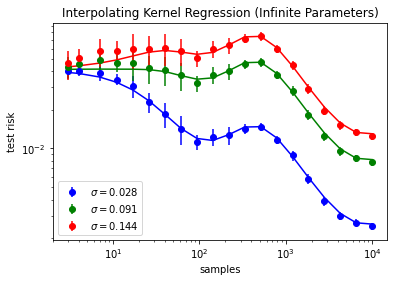

Neural Network Training Start @ 01-24_16-40
 P = 3, gen error: 0.0404 | train error: 2.061e-13 | Time Elapsed: 0h 2m 8s


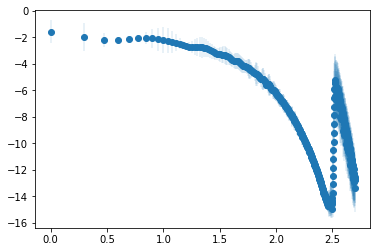

 P = 4, gen error: 0.0382 | train error: 6.782e-09 | Time Elapsed: 0h 2m 6s


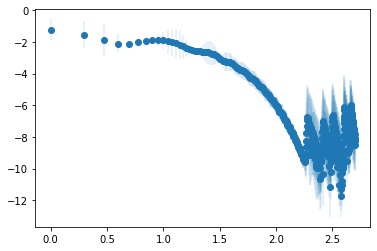

 P = 7, gen error: 0.0429 | train error: 1.199e-16 | Time Elapsed: 0h 2m 7s


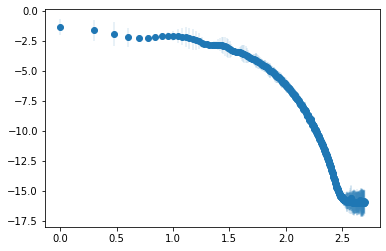

 P = 11, gen error: 0.0356 | train error: 1.578e-16 | Time Elapsed: 0h 2m 5s


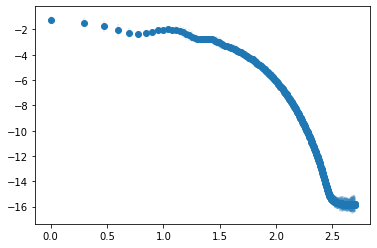

 P = 17, gen error: 0.0310 | train error: 1.503e-16 | Time Elapsed: 0h 2m 6s


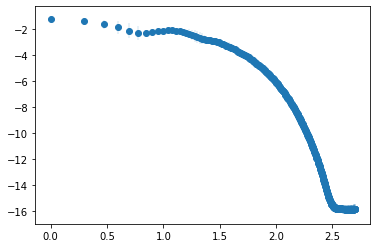

 P = 26, gen error: 0.0241 | train error: 2.294e-16 | Time Elapsed: 0h 2m 5s


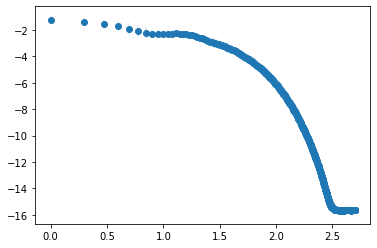

 P = 40, gen error: 0.0184 | train error: 1.851e-16 | Time Elapsed: 0h 2m 6s


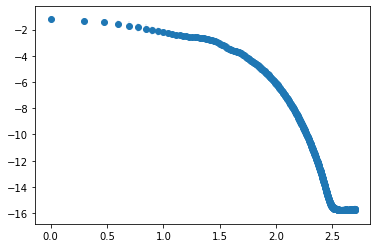

 P = 61, gen error: 0.0135 | train error: 2.122e-16 | Time Elapsed: 0h 2m 8s


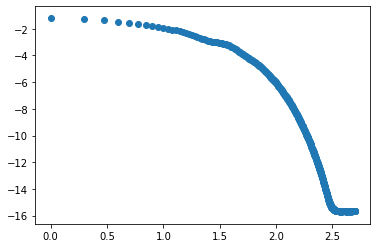

 P = 94, gen error: 0.0113 | train error: 2.074e-16 | Time Elapsed: 0h 2m 6s


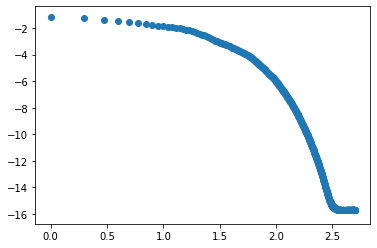

 P = 143, gen error: 0.0124 | train error: 2.122e-16 | Time Elapsed: 0h 2m 5s


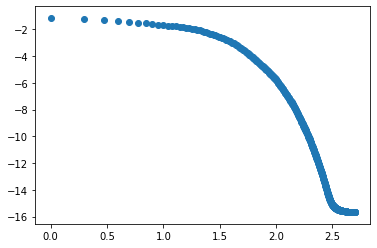

 P = 219, gen error: 0.0133 | train error: 4.184e-16 | Time Elapsed: 0h 2m 5s


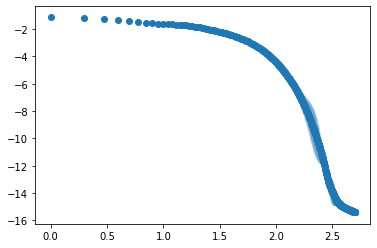

 P = 335, gen error: 0.0149 | train error: 1.046e-14 | Time Elapsed: 0h 2m 4s


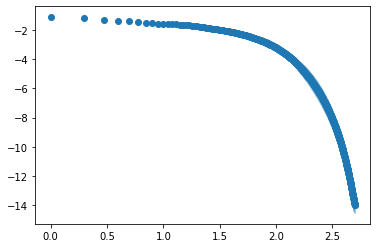

 P = 513, gen error: 0.0155 | train error: 1.757e-08 | Time Elapsed: 0h 2m 3s


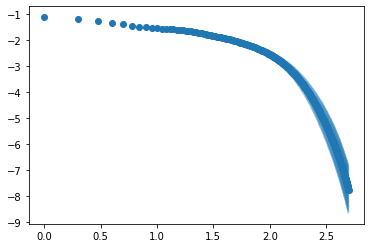

 P = 784, gen error: 0.0126 | train error: 9.631e-07 | Time Elapsed: 0h 2m 5s


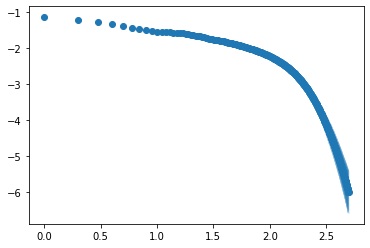

 P = 1199, gen error: 0.0100 | train error: 3.492e-06 | Time Elapsed: 0h 10m 25s


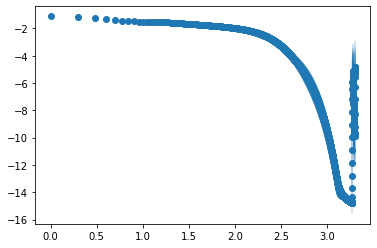

 P = 1832, gen error: 0.0068 | train error: 2.743e-06 | Time Elapsed: 0h 7m 58s


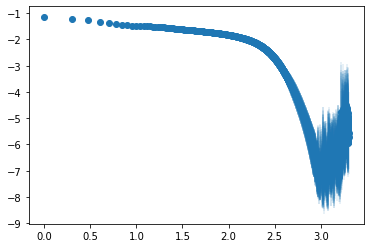

 P = 2801, gen error: 0.0046 | train error: 2.406e-06 | Time Elapsed: 0h 8m 36s


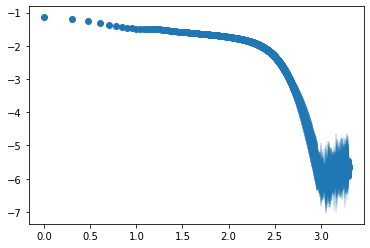

 P = 4281, gen error: 0.0039 | train error: 3.775e-06 | Time Elapsed: 0h 10m 27s


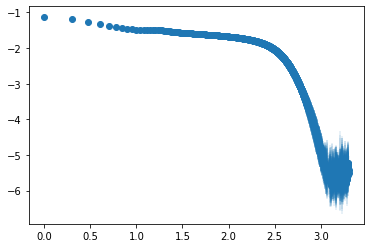

 P = 6543, gen error: 0.0039 | train error: 3.157e-06 | Time Elapsed: 0h 13m 39s


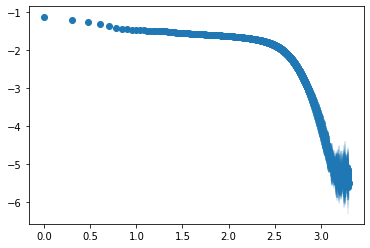

 P = 10000, gen error: 0.0042 | train error: 1.008e-05 | Time Elapsed: 0h 17m 46s


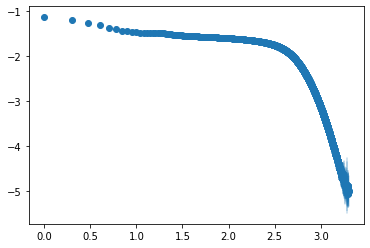

Total Time Elapsed: 1h 38m 25s


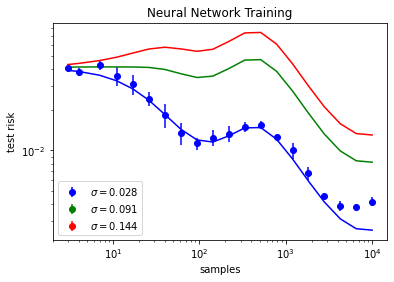

 P = 3, gen error: 0.0430 | train error: 2.806e-07 | Time Elapsed: 0h 2m 7s


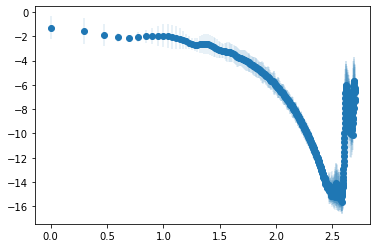

 P = 4, gen error: 0.0469 | train error: 2.447e-09 | Time Elapsed: 0h 2m 5s


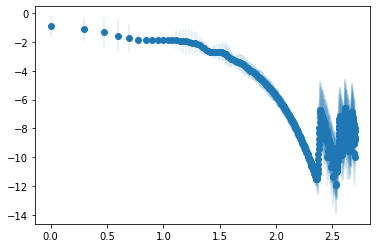

 P = 7, gen error: 0.0564 | train error: 1.355e-16 | Time Elapsed: 0h 2m 4s


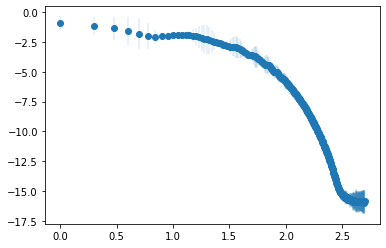

 P = 11, gen error: 0.0497 | train error: 2.332e-16 | Time Elapsed: 0h 2m 3s


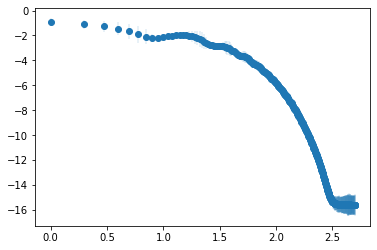

 P = 17, gen error: 0.0441 | train error: 2.659e-16 | Time Elapsed: 0h 2m 5s


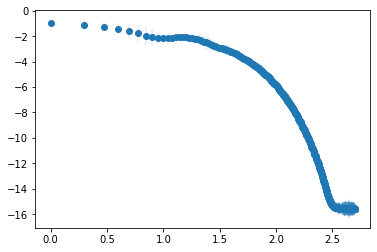

 P = 26, gen error: 0.0435 | train error: 3.287e-16 | Time Elapsed: 0h 2m 5s


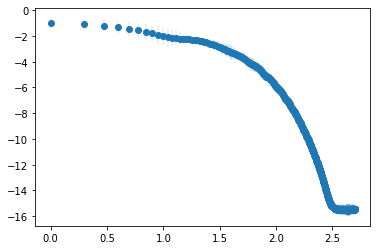

 P = 40, gen error: 0.0397 | train error: 2.844e-16 | Time Elapsed: 0h 2m 5s


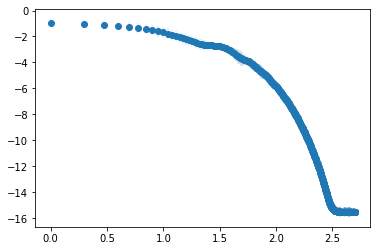

 P = 61, gen error: 0.0337 | train error: 3.761e-16 | Time Elapsed: 0h 2m 4s


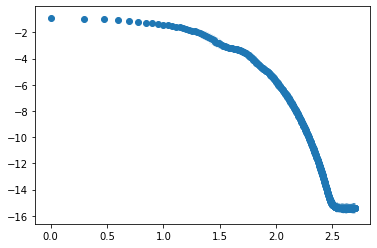

 P = 94, gen error: 0.0314 | train error: 3.248e-16 | Time Elapsed: 0h 2m 6s


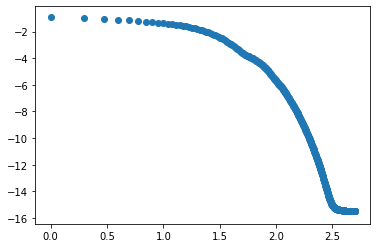

 P = 143, gen error: 0.0386 | train error: 4.234e-16 | Time Elapsed: 0h 2m 5s


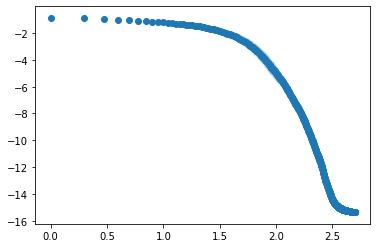

 P = 219, gen error: 0.0443 | train error: 8.230e-16 | Time Elapsed: 0h 2m 5s


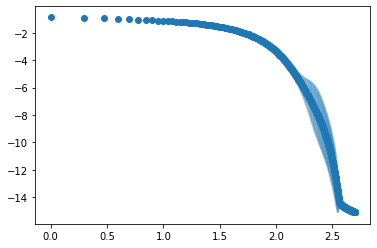

 P = 335, gen error: 0.0503 | train error: 1.814e-13 | Time Elapsed: 0h 2m 6s


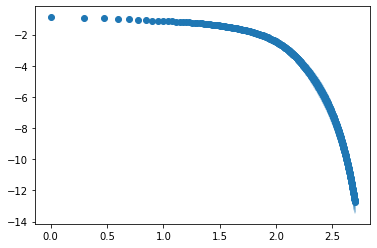

 P = 513, gen error: 0.0527 | train error: 3.254e-08 | Time Elapsed: 0h 2m 3s


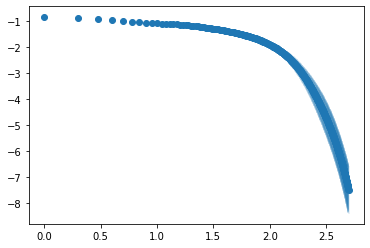

 P = 784, gen error: 0.0426 | train error: 1.202e-06 | Time Elapsed: 0h 2m 2s


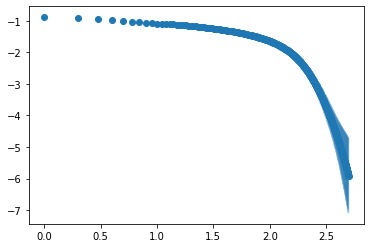

 P = 1199, gen error: 0.0334 | train error: 1.795e-05 | Time Elapsed: 0h 7m 59s


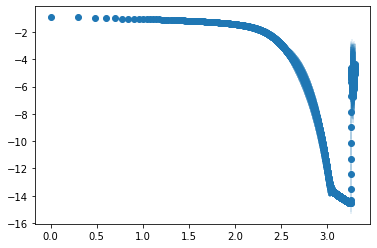

 P = 1832, gen error: 0.0225 | train error: 9.798e-07 | Time Elapsed: 0h 8m 2s


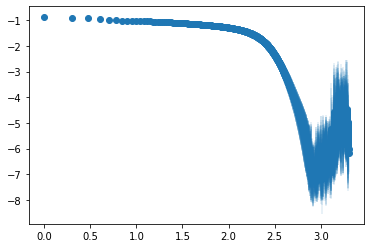

 P = 2801, gen error: 0.0151 | train error: 4.936e-06 | Time Elapsed: 0h 8m 36s


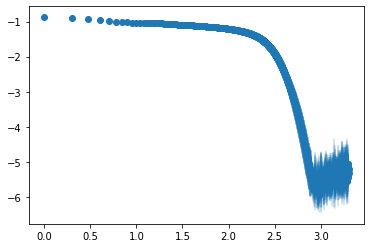

 P = 4281, gen error: 0.0126 | train error: 5.246e-06 | Time Elapsed: 0h 10m 30s


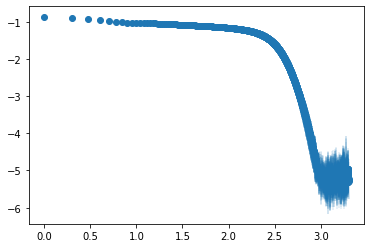

 P = 6543, gen error: 0.0125 | train error: 9.559e-06 | Time Elapsed: 0h 13m 40s


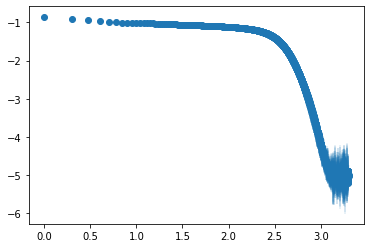

 P = 10000, gen error: 0.0136 | train error: 1.335e-05 | Time Elapsed: 0h 17m 48s


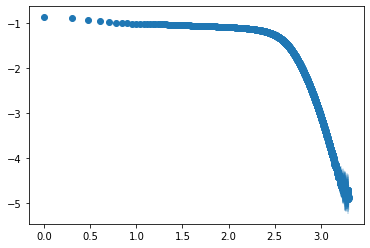

Total Time Elapsed: 1h 35m 52s


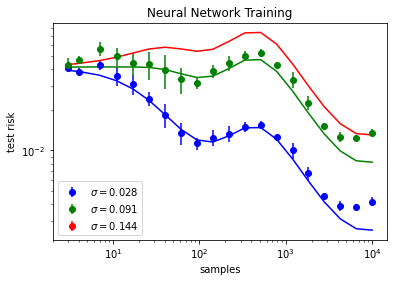

 P = 3, gen error: 0.0452 | train error: 1.313e-10 | Time Elapsed: 0h 2m 10s


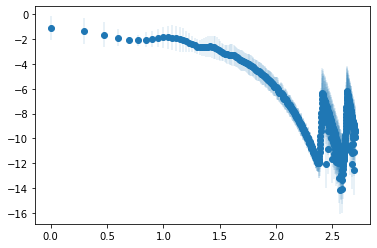

 P = 4, gen error: 0.0543 | train error: 1.728e-11 | Time Elapsed: 0h 2m 8s


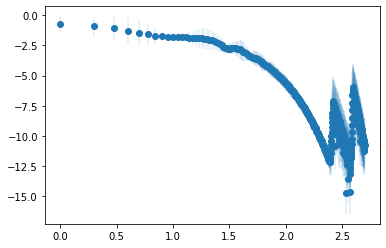

 P = 7, gen error: 0.0680 | train error: 1.527e-16 | Time Elapsed: 0h 2m 9s


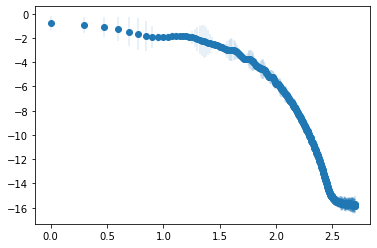

 P = 11, gen error: 0.0614 | train error: 1.645e-16 | Time Elapsed: 0h 2m 7s


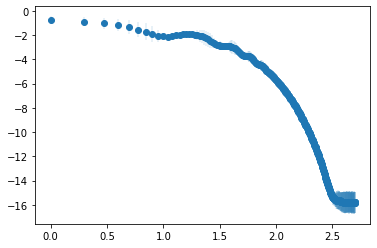

 P = 17, gen error: 0.0555 | train error: 3.950e-16 | Time Elapsed: 0h 2m 11s


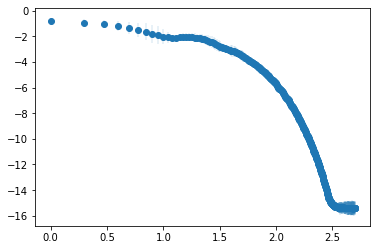

 P = 26, gen error: 0.0597 | train error: 3.477e-16 | Time Elapsed: 0h 2m 12s


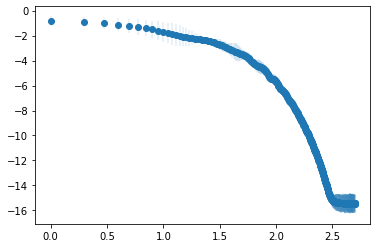

 P = 40, gen error: 0.0582 | train error: 3.584e-16 | Time Elapsed: 0h 2m 12s


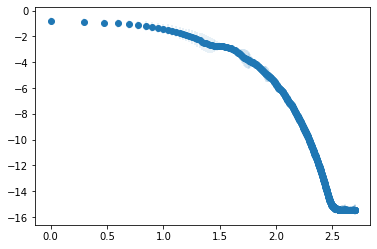

 P = 61, gen error: 0.0516 | train error: 3.880e-16 | Time Elapsed: 0h 2m 11s


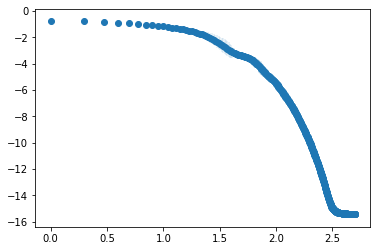

 P = 94, gen error: 0.0490 | train error: 4.241e-16 | Time Elapsed: 0h 2m 11s


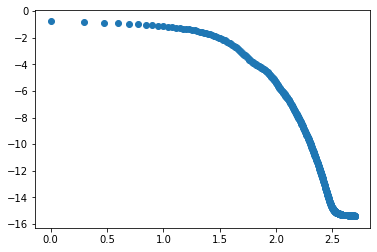

 P = 143, gen error: 0.0616 | train error: 5.183e-16 | Time Elapsed: 0h 2m 11s


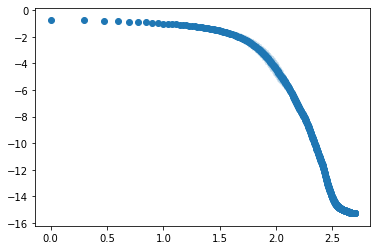

 P = 219, gen error: 0.0719 | train error: 1.108e-15 | Time Elapsed: 0h 2m 10s


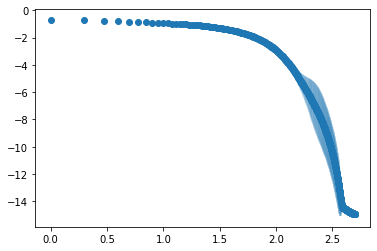

 P = 335, gen error: 0.0818 | train error: 2.009e-13 | Time Elapsed: 0h 2m 11s


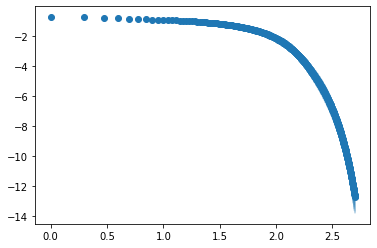

 P = 513, gen error: 0.0856 | train error: 2.571e-08 | Time Elapsed: 0h 2m 12s


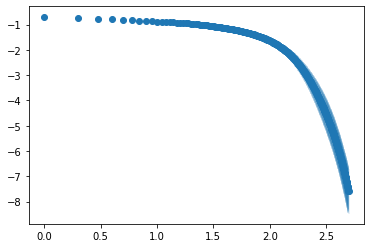

 P = 784, gen error: 0.0692 | train error: 1.148e-06 | Time Elapsed: 0h 2m 10s


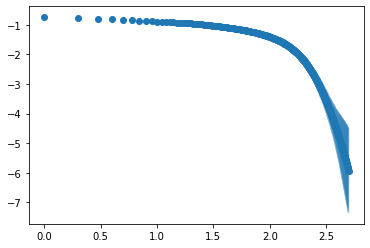

 P = 1199, gen error: 0.0539 | train error: 9.180e-06 | Time Elapsed: 0h 8m 23s


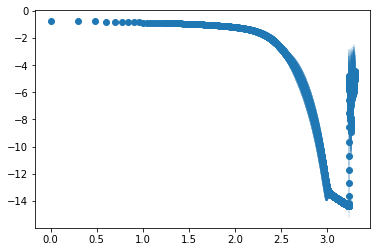

 P = 1832, gen error: 0.0363 | train error: 2.236e-05 | Time Elapsed: 0h 8m 4s


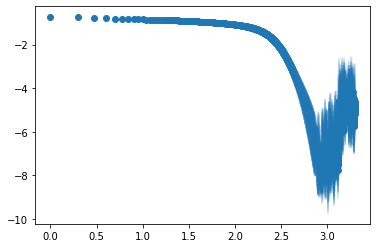

 P = 2801, gen error: 0.0243 | train error: 5.712e-06 | Time Elapsed: 0h 8m 42s


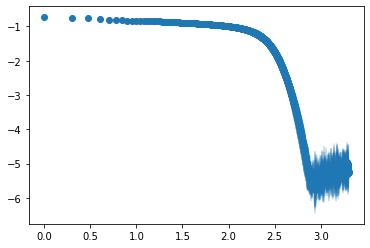

 P = 4281, gen error: 0.0201 | train error: 8.670e-06 | Time Elapsed: 0h 10m 32s


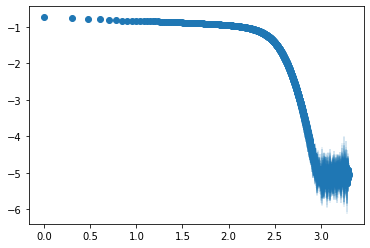

 P = 6543, gen error: 0.0199 | train error: 1.002e-05 | Time Elapsed: 0h 13m 39s


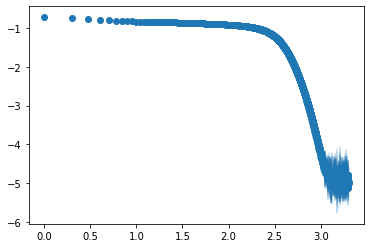

 P = 10000, gen error: 0.0217 | train error: 1.762e-05 | Time Elapsed: 0h 17m 48s


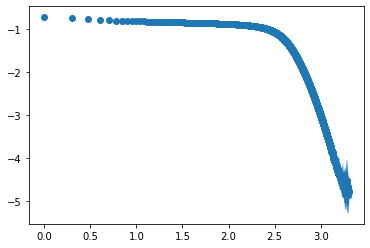

Total Time Elapsed: 1h 37m 46s


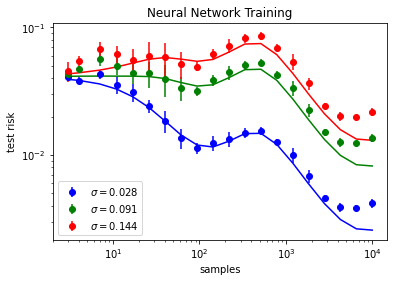

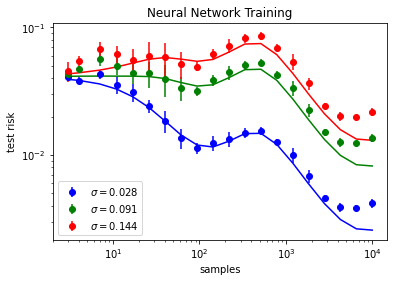

In [ ]:
timestamp = time_now()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Experiment Parameters
num_repeats_ker = 15 #150
num_repeats_nn = 5 #5
num_iter_nn = 500

## NN Hyperparameters
lr = 0.008
width = 2000
layers = 1
ensemble_size_list = [20]

## Dimension, sample sizes, max eigenvalue mode
dim = 25
pvals = npo.logspace(0.5, 4, num = 20).astype('int')
p_test = 1500
kmax = 200

## Target function mode and label noise
fn_mode = 1
noise_num = 1
shift = npo.array([-0.8, 0, 1])

key = random.PRNGKey(0)
all_keys = random.split(key, max(num_repeats_nn, num_repeats_ker))

if save_data:
  parent = save_dir + 'NNExp_width_%d-layer_%d-fn_mode_%d/'%(width,layers,fn_mode)
  ensure_dir(parent)

# create NN and kernel function
init_fn, apply_fn, kernel_fn = fully_connected(layers, width)
apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnums=(2,))

# Generate Theory curves and Noise
Sol, Errs_tot, noise, alpha_s, spectrum, degens = NTK_theory_and_Noise(pvals, layers, dim, kmax, noise_num, shift, 
                                                                        fn_mode = fn_mode, zero_mode=False)

params = {'dim': dim, 'kmax': kmax, 'layer': layers, 'width': width,
          'test_samp': p_test, 'num_repeat_ker': num_repeats_ker, 
          'num_repeat_nn': num_repeats_nn, 'num_iter_nn': num_iter_nn, 
          'noise': noise, 'noise_num': noise_num, 'shift': shift, 
          'ensemble_size_list': ensemble_size_list, 'fn_mode': fn_mode, 
          'alpha_s': alpha_s, 'degens': degens}

if save_data:
  filename_theory = parent + timestamp + 'error_theory.npz'
  np.savez(filename_theory, pvals, Sol, Errs_tot, params)

### Start the kernel experiment

err_regression = npo.zeros((noise_num, len(shift), len(pvals)))
std_regression = npo.zeros((noise_num, len(shift), len(pvals)))

print('Kernel Regression Start @ ' + time_now())
for i in range(noise_num):
  t_start = datetime.now()
  for j in range(len(shift)):
    data = kernel_expt(kernel_fn, pvals, p_test, noise[i, j], dim, spectrum, num_repeats_ker, all_keys, fn_mode = fn_mode)
    err_regression[i, j] = data[0]
    std_regression[i, j] = data[1]
  
  t_end = datetime.now()
  print('Time Elapsed: ' + time_diff(t_start,t_end))

  plot_shift_data(pvals, err_regression, std_regression, Errs_tot, i, noise, 'kernel')

if save_data: 
  filename_exp = parent + timestamp + 'error_exp_kernel.npz'
  np.savez(filename_exp, err_regression, std_regression)

# NN experiment: repeat the same experiment as before...
for ensemble_size in ensemble_size_list:
  if save_data:
    directory = parent + 'ensamble_%d/'%(ensemble_size)
    ensure_dir(directory)

  ### Start Neural Network experiment
  err_NN = npo.zeros((noise_num, len(shift), len(pvals)))
  std_NN = npo.zeros((noise_num, len(shift), len(pvals)))

  tr_err_NN = []
  std_tr_err_NN = []

  print('Neural Network Training Start @ ' + time_now())
  for i in range(noise_num):
    for j in range(len(shift)):
      data = nn_expt(init_fn, apply_fn, pvals, p_test, noise[i,j], dim, spectrum, 
                     num_repeats_nn, all_keys, lr, num_iter_nn, 
                     fn_mode = fn_mode, ensemble_size = ensemble_size)
      
      err_NN[i, j] = data[0]
      std_NN[i, j] = data[1]
      tr_err_NN += [data[2]]
      std_tr_err_NN += [data[3]]

      if save_data:
        filename_exp = directory + timestamp + 'shift_' + str(j) + '_error_exp_NN.npz'
        np.savez(filename_exp, err_NN, std_NN, tr_err_NN, std_tr_err_NN)
      
      plot_shift_data(pvals, err_NN, std_NN, Errs_tot, i, noise, 'NN')

    plot_shift_data(pvals, err_NN, std_NN, Errs_tot, i, noise, 'NN')

  filename_exp = directory + timestamp + 'final_error_exp_NN.npz'
  if save_data: np.savez(filename_exp, err_NN, std_NN, tr_err_NN, std_tr_err_NN)